In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("/kaggle/input/caloriecast-adaptive-ensemble-engine-for-s5e5/submission.csv")
df1.to_csv( 'adaptive-ensemble-engine_submission.csv', index=False)  #0.05670

df2 = pd.read_csv("/kaggle/input/ensemble-of-solutions/submission.csv")
df2.to_csv( 'Ensemble_submission.csv', index=False)   # 0.05668

df3 = pd.read_csv("/kaggle/input/ps-s5e5-log-blended-cat-xgboost-with-50-fold-cv/ensemble_submission.csv")
df3.to_csv( 'log-blended-cat-xgboost-with-50-fold-cv_submission.csv', index=False)  # 0.05670

df4 = pd.read_csv("/kaggle/input/ps-s5e5-cross-masked-ensemble/submission.csv")
df4.to_csv( 'cross-masked-ensemble_submission.csv', index=False)  # 0.05680

df5 = pd.read_csv("/kaggle/input/ps-s5e5-calorie-prediction-ensemble/submission.csv")
df5.to_csv( 'trippleEnsemble_submission.csv', index=False)     # 0.05667 

df6 = pd.read_csv("/kaggle/input/ps-s5e5-catboost-xgboost-feature-engineering/submission.csv")
df6.to_csv( 'catboost-xgboost-feature-engineering_submission.csv', index=False)   # 0.05679

df7 = pd.read_csv("/kaggle/input/pce-v1/submission.csv")
df7.to_csv( 'XG_Catboost_FE_submission.csv', index=False)   # 0.05668

df8 = pd.read_csv("/kaggle/input/calorie-best-fe/submission.csv")
df8.to_csv( 'calorie-best-fe_submission.csv', index=False)   # 0.05667


#df9 = pd.read_csv("/kaggle/input/calories-expenditure/submission.csv")  # 0.05692
#df10 = pd.read_csv("/kaggle/input/best-fe-3-diverse-models/submission_.csv") #0.05669


df11 = pd.read_csv("/kaggle/input/calorie-expenditure-female-vs-male/submission.csv")
df11.to_csv( 'male_female_submission.csv', index=False)   # 0.05667


df12 = pd.read_csv("/kaggle/input/kmeans-clustering-based-fe-improves-cv-lb-scores/submission.csv")
df12.to_csv( 'kmean_submission.csv', index=False)   # 0.05695 V2


df13 = pd.read_csv("/kaggle/input/s5e5-xgb-cat-lgbm-meta-models/submission.csv")
df13.to_csv( 'metamodel_submission.csv', index=False)   # 0.05695 V2



ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")  







In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def safe_ensemble(model_dfs, sample_submission, output_prefix="submission"):

    model_names = [f"model_{i}" for i in range(len(model_dfs))]
    all_preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)

    print(f"Loaded {len(model_dfs)} models.")

    # --- 1. Model correlation matrix ---
    corr_matrix = np.corrcoef(all_preds.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".4f", xticklabels=model_names, yticklabels=model_names, cmap='coolwarm')
    plt.title("Correlation Between Model Predictions")
    plt.show()

    # --- 2. Robust ensembling ---

    # Mean
    sample_submission['Calories'] = np.mean(all_preds, axis=1)
    sample_submission.to_csv(f"{output_prefix}_mean.csv", index=False)

    # Median
    sample_submission['Calories'] = np.median(all_preds, axis=1)
    sample_submission.to_csv(f"{output_prefix}_median.csv", index=False)

    # Trimmed mean (exclude top 2 and bottom 2)
    sorted_preds = np.sort(all_preds, axis=1)
    trimmed_preds = np.mean(sorted_preds[:, 2:-2], axis=1)
    sample_submission['Calories'] = trimmed_preds
    sample_submission.to_csv(f"{output_prefix}_trimmed_mean.csv", index=False)

    # Weighted average by inverse standard deviation (lower std = more stable)
    stds = np.std(all_preds, axis=0)
    weights = 1 / (stds + 1e-6)
    weights /= weights.sum()
    weighted_preds = (all_preds * weights).sum(axis=1)
    sample_submission['Calories'] = weighted_preds
    sample_submission.to_csv(f"{output_prefix}_weighted_std.csv", index=False)

    # --- 3. Leave-one-out ensemble influence ---
    print("\nLeave-One-Out Median Ensemble:")
    for i, name in enumerate(model_names):
        partial_preds = np.delete(all_preds, i, axis=1)
        median_preds = np.median(partial_preds, axis=1)
        print(f"Without {name}: mean prediction = {median_preds.mean():.5f}, std = {median_preds.std():.5f}")

    print("\nSubmissions saved with mean, median, trimmed mean, and weighted average.")



Loaded 11 models.


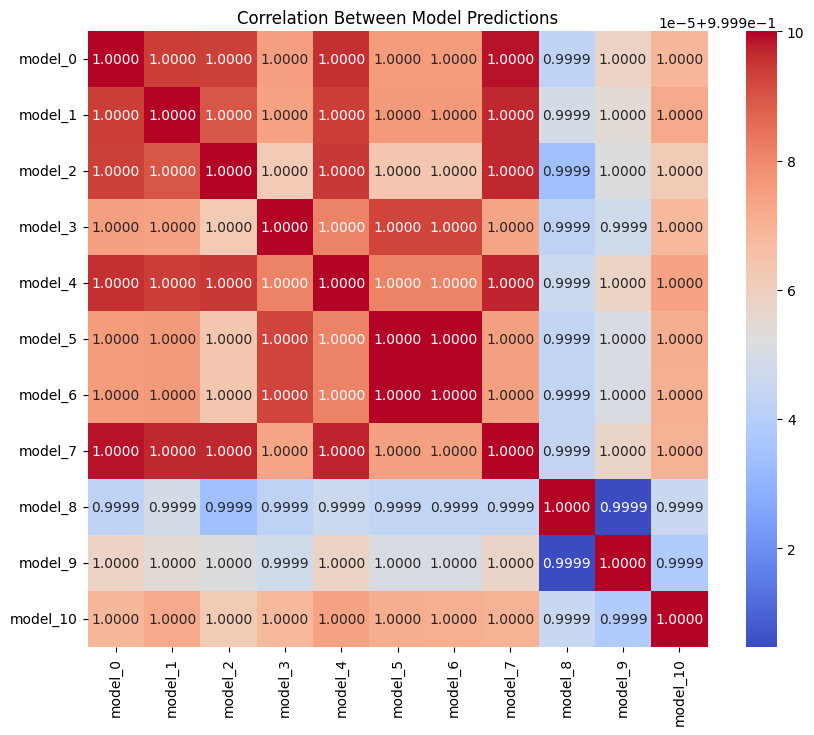


Leave-One-Out Median Ensemble:
Without model_0: mean prediction = 88.15664, std = 62.23959
Without model_1: mean prediction = 88.15972, std = 62.24937
Without model_2: mean prediction = 88.15607, std = 62.24077
Without model_3: mean prediction = 88.15270, std = 62.23361
Without model_4: mean prediction = 88.15467, std = 62.23771
Without model_5: mean prediction = 88.15271, std = 62.23371
Without model_6: mean prediction = 88.15272, std = 62.23373
Without model_7: mean prediction = 88.15742, std = 62.24295
Without model_8: mean prediction = 88.15306, std = 62.23498
Without model_9: mean prediction = 88.15341, std = 62.23594
Without model_10: mean prediction = 88.15249, std = 62.23381

Submissions saved with mean, median, trimmed mean, and weighted average.


In [3]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df11, df12, df13]
ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

safe_ensemble(dfs, ground_truth.copy())
